Bibliografía

https://towardsdatascience.com/journey-to-the-center-of-multi-label-classification-384c40229bff

# Carga de librerias

In [1]:
# ktrain is a Python library that makes deep learning and AI
# more accessible and easier to apply
%%capture
!pip install --upgrade pip -q
!pip install -q ktrain

In [2]:
%%capture
!pip install torch_xla

In [3]:
import ktrain
from ktrain import text
import tensorflow as tf
import numpy as np
import time
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split



# TPU, GPU

In [ ]:
# # Preparing for TPU usage
# import torch_xla
# import torch_xla.core.xla_model as xm
# device = xm.xla_device()

In [ ]:
# Setting up the device for GPU usage

# from torch import cuda
# device = 'cuda' if cuda.is_available() else 'cpu'

In [6]:

# physical_devices = tf.config.list_physical_devices('GPU')
# tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [5]:
# physical_devices

In [ ]:
# !nvidia-smi

In [4]:
df = pd.read_csv("Emotion_classify_Data.csv")

In [5]:
df.shape

(5937, 2)

In [6]:
df.columns

Index(['Comment', 'Emotion'], dtype='object')

In [7]:
df.head(3)

,Comment,Emotion
0,i seriously hate one subject to death but now ...,fear
1,im so full of life i feel appalled,anger
2,i sit here to write i start to dig out my feel...,fear


In [8]:
df.Emotion.value_counts()

Emotion
anger    2000
joy      2000
fear     1937
Name: count, dtype: int64

In [9]:
#number of different values in the practice area column:
df['Emotion'].nunique()

3

## Preprop

Descartamos los datos nulos y las duplicaciones:

In [10]:
df1 = df.copy()

In [11]:
df1.dropna(inplace=True)
df1 = df1.drop_duplicates().reset_index(drop=True)

Limpiamos las etiquetas:

In [12]:
# Función para dividir y eliminar espacios adicionales
def split_strip(x):
    return [i.strip() for i in x.split(',')]

In [13]:
df1['Comment'] = df1['Comment'].apply(lambda x: split_strip(x))

In [14]:
# observamos las diferencias luego de aplicar la funcion
print(df['Comment'][1])
print(df1['Comment'][1])

im so full of life i feel appalled
['im so full of life i feel appalled']


quitamos la lista que nos devuelve la función con el método 'explode':

In [15]:
df1 = df1.explode('Comment')

In [16]:
print(df1['Comment'][1])

im so full of life i feel appalled


## Brief EDA

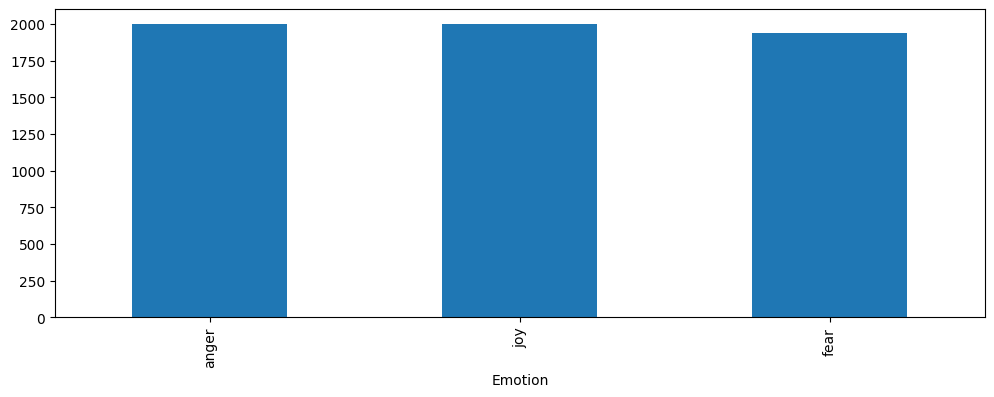

In [20]:
import matplotlib.pyplot as plt

pa_value_counts = df1['Emotion'].value_counts()

plt.figure(figsize=(12,4))
pa_value_counts.plot(kind='bar')
plt.show()

Ahora en porcentajes

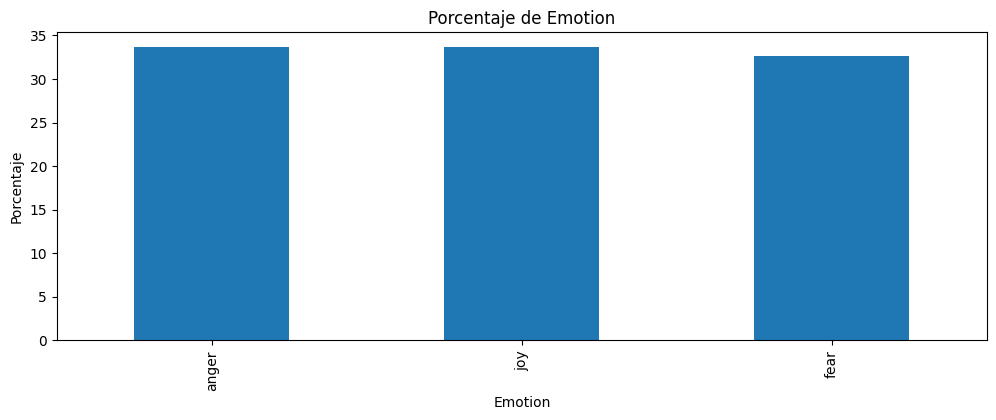

In [21]:

pa_percentages = pa_value_counts / pa_value_counts.sum() * 100

plt.figure(figsize=(12,4))
pa_percentages.plot(kind='bar')
plt.title('Porcentaje de Emotion')
plt.xlabel('Emotion')
plt.ylabel('Porcentaje')
plt.show()


Wordcloud de principales palabras

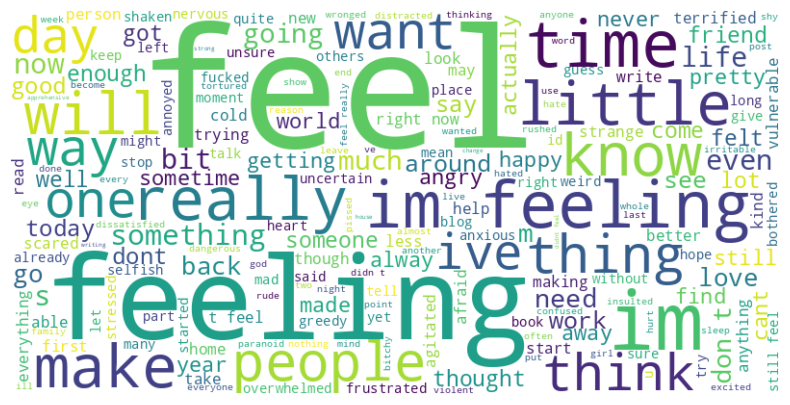

In [23]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Supongamos que tienes un DataFrame df1 con la columna 'attorney_bio'
# Asegúrate de tener instalada la biblioteca WordCloud usando: pip install wordcloud

# Combina todos los textos en una sola cadena
text = ' '.join(df1['Comment'].astype(str))

# Crea la WordCloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Muestra la WordCloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


Cómo se ven los textos en algunas categoria:

In [26]:
print(f"label: Fear, Text:\n{df1.loc[df1.Emotion == 'fear'].sample(1)[['Comment']].to_string(index=False)}")
print('-----------------------------------------------------------------------------------------------------\n')
print(f"label: joy, Text:\n{df1.loc[df1.Emotion == 'joy'].sample(1)[['Comment']].to_string(index=False)}")
print('-----------------------------------------------------------------------------------------------------\n')
print(f"label: anger, Text:\n{df1.loc[df1.Emotion == 'anger'].sample(1)[['Comment']].to_string(index=False)}")
print('-----------------------------------------------------------------------------------------------------\n')

label: Fear, Text:
                                                                                                      Comment
i was tired of feeling like a helpless victim and stuck in my circumstances and slowly started making changes
-----------------------------------------------------------------------------------------------------

label: joy, Text:
                                                                                                                       Comment
i woke up feeling incredibly content amp optimistic today however i woke up with a terrible cold and a complete lack of energy
-----------------------------------------------------------------------------------------------------

label: anger, Text:
                             Comment
i think i was right to feel insulted
-----------------------------------------------------------------------------------------------------



# Bert

## Split data

In [58]:
# X = df1['Comment'].tolist()
# y = df1['Emotion'].tolist()

In [59]:
# x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [17]:
data_train, data_test = train_test_split(df1, test_size=0.3, random_state=42)
print(f'data_train shape: {data_train.shape}')
print(f'data_test shape: {data_test.shape}')

data_train shape: (4155, 2)
data_test shape: (1782, 2)


In [24]:

categories = df1['Emotion'].unique()

print('size of training set: %s' % (len(data_train)))
print('size of validation set: %s' % (len(data_test)))
print('classes: %s' % (categories))

x_train = np.array(data_train['Comment'])
y_train =  np.array(data_train['Emotion'])
x_test =  np.array(data_test['Comment'])
y_test =  np.array(data_test['Emotion'])

size of training set: 4155
size of validation set: 1782
classes: ['fear' 'anger' 'joy']


In [25]:
(x_train,  y_train), (x_test, y_test), preproc = text.texts_from_array(x_train=x_train, y_train=y_train,
                                                                       x_test=x_test, y_test=y_test,
                                                                       class_names=categories,
                                                                       preprocess_mode='bert',
                                                                       maxlen=350,
                                                                       max_features=35000)



preprocessing train...
language: en


Is Multi-Label? False
preprocessing test...
language: en


/usr/local/lib/python3.10/dist-packages/ktrain/utils.py:744: UserWarning: class_names argument was ignored, as they were extracted from string labels in dataset
  warnings.warn(


task: text classification


##  Load the BERT Model and Instantiate a Learner object

In [28]:
# you can disregard the deprecation warnings arising from using Keras 2.2.4 with TensorFlow 1.14.
model = text.text_classifier('bert', train_data=(x_train, y_train), preproc=preproc)
learner = ktrain.get_learner(model, train_data=(x_train, y_train), batch_size=6)

Is Multi-Label? False
maxlen is 350
done.


Train the Model

In [29]:
learner.fit_onecycle(2e-5, 4)



begin training using onecycle policy with max lr of 2e-05...
Epoch 1/4
693/693 [==============================] - 400s 539ms/step - loss: 0.6795 - accuracy: 0.6809
Epoch 2/4
693/693 [==============================] - 373s 538ms/step - loss: 0.1458 - accuracy: 0.9504
Epoch 3/4
693/693 [==============================] - 373s 538ms/step - loss: 0.0511 - accuracy: 0.9810
Epoch 4/4
693/693 [==============================] - 373s 538ms/step - loss: 0.0207 - accuracy: 0.9921


In [31]:
learner.validate(val_data=(x_test, y_test))

56/56 [==============================] - 53s 944ms/step
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       600
           1       0.96      0.96      0.96       614
           2       0.99      0.97      0.98       568

    accuracy                           0.97      1782
   macro avg       0.97      0.97      0.97      1782
weighted avg       0.97      0.97      0.97      1782



array([[582,  13,   5],
       [ 22, 590,   2],
       [  7,  10, 551]])

# How to Use Our Trained BERT Model

In [32]:
predictor = ktrain.get_predictor(learner.model, preproc)

In [33]:
predictor.get_classes()

['anger', 'fear', 'joy']

In [37]:
df1['Comment'][0]

'i seriously hate one subject to death but now i feel reluctant to drop it'

In [38]:
predictor.predict(df1['Comment'][0])

'fear'

In [39]:
#we can check the label:
df1['Emotion'][0]


'fear'

In [41]:
text1 = "His clenched fists and furrowed brow betrayed his simmering anger."
text2 = "She buried her face in her hands, tears streaming down her cheeks, overwhelmed by anguish."
text3 =" With a wide grin and sparkling eyes, he danced around the room, exuding pure joy."

In [42]:
predictor.predict(text1)

'anger'

In [43]:
predictor.predict(text2)

'fear'

In [44]:
predictor.predict(text3)

'joy'